In [3]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import logging
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
import tensorflow as tf
import re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
import pickle
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from yellowbrick.text import FreqDistVisualizer
from scipy import interp
from itertools import cycle
import matplotlib
import umap.plot
from wordcloud import WordCloud, ImageColorGenerator
from imblearn.over_sampling import RandomOverSampler

In [4]:
df = pd.read_csv('master_f.csv')
df.fillna(method = 'pad')

df_dep = df.loc[df['label'] == 0] 
df_ptsd = df.loc[df['label'] == 1]
df_cptsd = df.loc[df['label'] == 2] 
df_bpd = df.loc[df['label'] == 3]
df_bipolar = df.loc[df['label'] == 4] 
df_diss = df.loc[df['label'] == 5]

df_dep_holdout = df_dep.iloc[:5]
df_ptsd_holdout = df_ptsd.iloc[:5]
df_cptsd_holdout = df_cptsd.iloc[:5]
df_bpd_holdout = df_bpd.iloc[:5]
df_bipolar_holdout = df_bipolar.iloc[:5]
df_diss_holdout = df_diss.iloc[:5]

df_dep = df_dep.iloc[5:]
df_ptsd = df_ptsd.iloc[5:]
df_cptsd = df_cptsd.iloc[5:]
df_bpd = df_bpd.iloc[5:]
df_bipolar = df_bipolar.iloc[5:]
df_diss = df_diss.iloc[5:]

df = pd.concat([df_dep, df_ptsd, df_cptsd, df_bpd, df_bipolar, df_diss])
df_holdout = pd.concat([df_dep_holdout, df_ptsd_holdout, df_cptsd_holdout, df_bpd_holdout, df_bipolar_holdout, df_diss_holdout])
df.dropna()

print(df.shape)
print(df.keys())

(10091, 2)
Index(['label', 'text'], dtype='object')


In [5]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
TOKENIZER = RegexpTokenizer(r'\w+')
LEMMATIZER = WordNetLemmatizer()
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text)
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(x for x in text.split() if x not in STOPWORDS) # delete stopwors from text
    return text

def word_lemmatizer(text):
    lem_text = [LEMMATIZER.lemmatize(x) for x in text]
    return lem_text  

df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(lambda x: TOKENIZER.tokenize(x))
df['text'] = df['text'].apply(lambda x: word_lemmatizer(x))

df = df.dropna(how='any',axis=0)
df.shape

(10091, 2)

In [6]:
corpus = []
for document in df['text']:
    exclude_list = ['anyone', 'else', 'feel', 'like', "don't", 'know', "I'm", 'new', '[]']
    for text in document:
        if text not in exclude_list:
            corpus.append(text)
        
fd = nltk.FreqDist(corpus)
print(fd.most_common(20))

[('im', 15481), ('dont', 9693), ('time', 7585), ('get', 7045), ('want', 6205), ('thing', 6111), ('ive', 5985), ('year', 5957), ('really', 5824), ('people', 5670), ('life', 5574), ('would', 5345), ('one', 5162), ('day', 4933), ('even', 4883), ('think', 4727), ('cant', 4556), ('go', 4406), ('feeling', 4095), ('much', 3951)]


In [7]:
text = nltk.Text(corpus)
concordance_list = text.concordance_list("want", lines=20)
for entry in concordance_list:
    print(entry.line)
finder = nltk.collocations.QuadgramCollocationFinder.from_words(text)
finder_list = finder.ngram_fd.most_common(20)
for find in finder_list:
    print(find)

uined honor he locking 3 month didnt want go back work im living house live di
afraid tired everyday nightmare dont want lose life person fell love dont plea
en week really struggling experience want come home need stay longer get medic
ng promoted afford monthly rent plus want emergency saving fund live mother cl
r anybody relate advice thanks hi dr want sign two week go ahead go work dr gi
ress let honest get lot stress would want come home hurt see depression suicid
eaceful dreamy 3 hour ever rare dont want want wake much better time asleep sa
ul dreamy 3 hour ever rare dont want want wake much better time asleep sad dep
t face name others similar situation want tell wont last well spend sunny day 
fear losing mom shes one trust world want die hopeless im starting get anger i
onfident sexy hate negative attitude want stop therapy support group im gonna 
cing pretend im happy positive didnt want throw hand say amazing instead looke
ad said im really uncomfortable dont want talk immat

In [8]:
pd.isnull(df).sum() > 0

label    False
text     False
dtype: bool

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
docs = df['text'].astype(str).dropna()
vectorizer = TfidfVectorizer(stop_words='english', 
                             min_df = 5,
                             ngram_range = (1,2),
                             use_idf = True,
                             max_df = 0.2, 
                             smooth_idf=True)
label_map = {0: 'Depression',
             1: 'PTSD',
             2: 'CPTSD',
             3: 'Borderline',
             4: 'Bipolar',
             5: 'Dissociation'}
X = vectorizer.fit_transform(docs).toarray()
y = df['label'].values
y_label = df['label'].map(label_map)

print(X.shape) # check shape of the document-term matrix
y.shape

(10091, 25341)


(10091,)

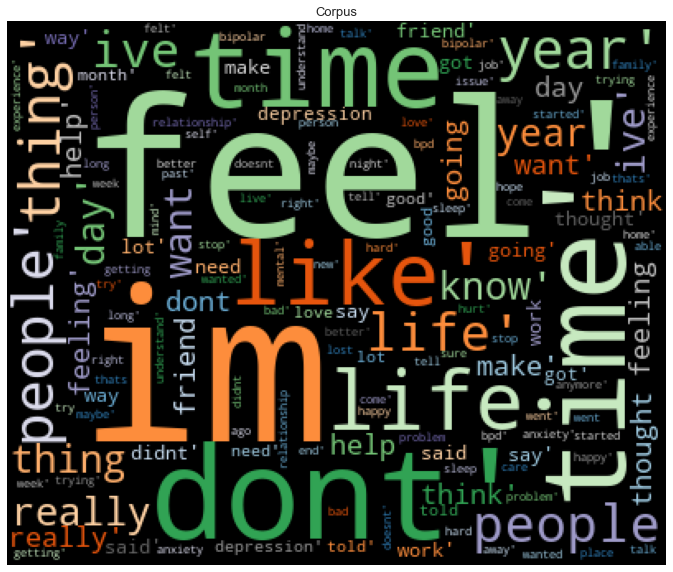

In [10]:
exclude_list = ['anyone', 'else', 'feel', 'like', "don't", 'know', "im'", 'new']
features = vectorizer.get_feature_names()

def generate_wordcloud(data, title):
    cloud = WordCloud(width=400,
                      height=330,
                      max_words=150,
                      colormap='tab20c',
                      stopwords=exclude_list,
                      collocations=True).generate_from_text(data)
    plt.figure(figsize=(14,10))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title, fontsize=13)
    plt.show()
    
generate_wordcloud(str(features), 'Corpus')

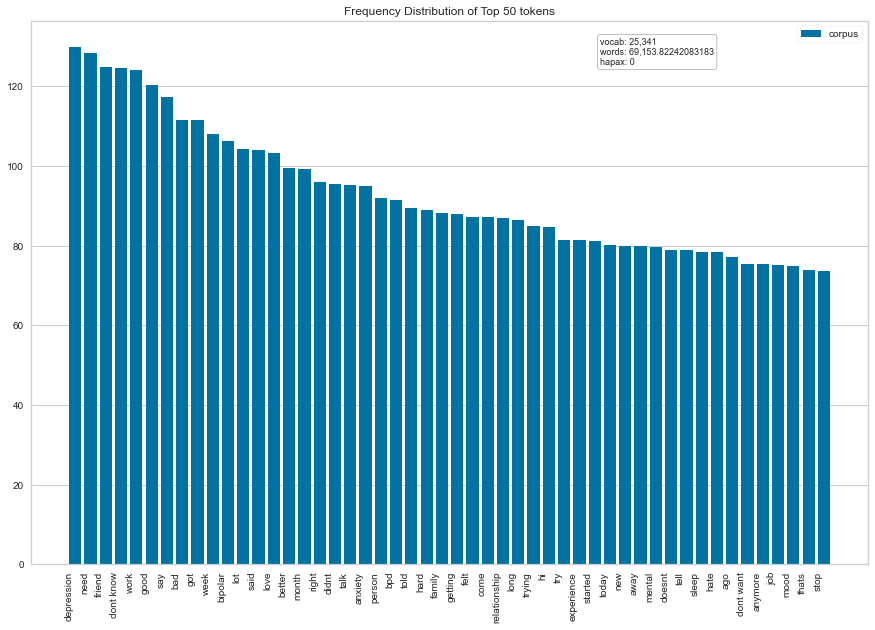

<Figure size 576x396 with 0 Axes>

In [11]:
features = vectorizer.get_feature_names()
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient='v', size=(1080,720))
visualizer.fit(X)
visualizer.show()
plt.savefig('top_50.png', dpi=500)

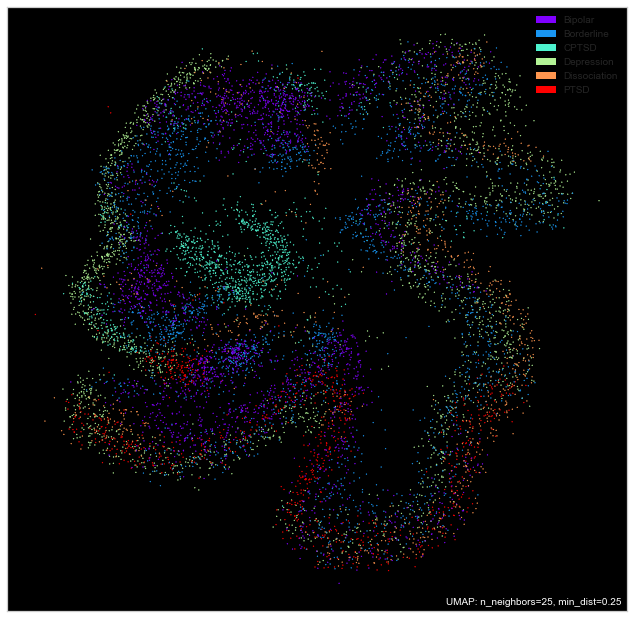

In [15]:
mapper = umap.UMAP(n_neighbors=25, min_dist=.1).fit(X)

%matplotlib inline
umap.plot.points(mapper, labels=y_label, theme='fire')
plt.savefig('dimension_reduced.png', dpi=500)

In [16]:
hover_data = pd.DataFrame({'index': np.arange(len(y)),
                           'label': y})
hover_data['item'] = hover_data.label.map({0:'depression',
                                           1:'ptsd',
                                           2:'cptsd',
                                           3:'bpd',
                                           4:'bipolar',
                                           5:'dissociation'})

umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=y, hover_data=hover_data, point_size=2)
umap.plot.show(p)

Loading BokehJS ...

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\umap\plot.py:855: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  "Hammer edge bundling is expensive for large graphs!\n"


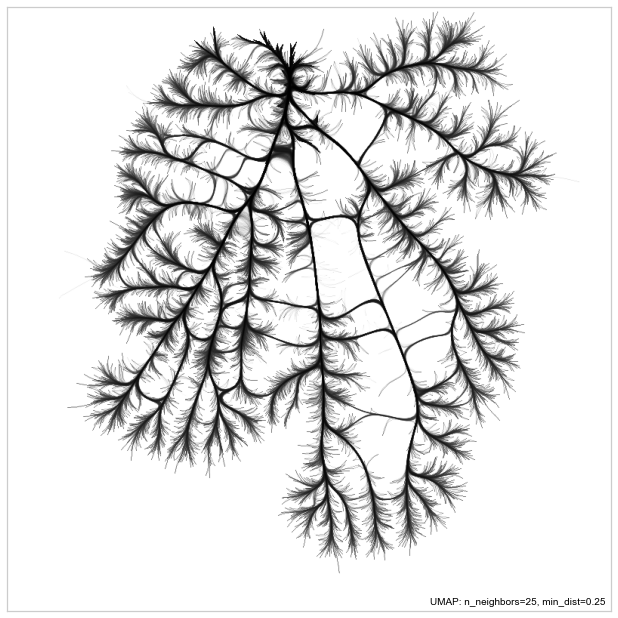

In [17]:
%matplotlib inline
umap.plot.connectivity(mapper, edge_bundling='hammer')
plt.savefig('comorbidity.png', dpi=500)

Text(0.5, 1.0, 'Classes Distribution')

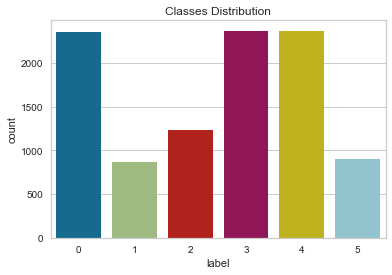

In [18]:
sns.countplot(x='label', data=df)
plt.title("Classes Distribution")

In [19]:
ovs = RandomOverSampler(random_state=42)
X_res, y_res = ovs.fit_resample(X,y)

In [20]:
print("original class counts: " + str(pd.value_counts(y.ravel())))
print("new class counts: " + str(pd.value_counts(y_res.ravel())))

original class counts: 4    2370
3    2364
0    2361
2    1228
5     906
1     862
dtype: int64
new class counts: 0    2370
1    2370
2    2370
3    2370
4    2370
5    2370
dtype: int64


In [21]:
X_res.shape

(14220, 25341)

In [22]:
y_res.shape

(14220,)

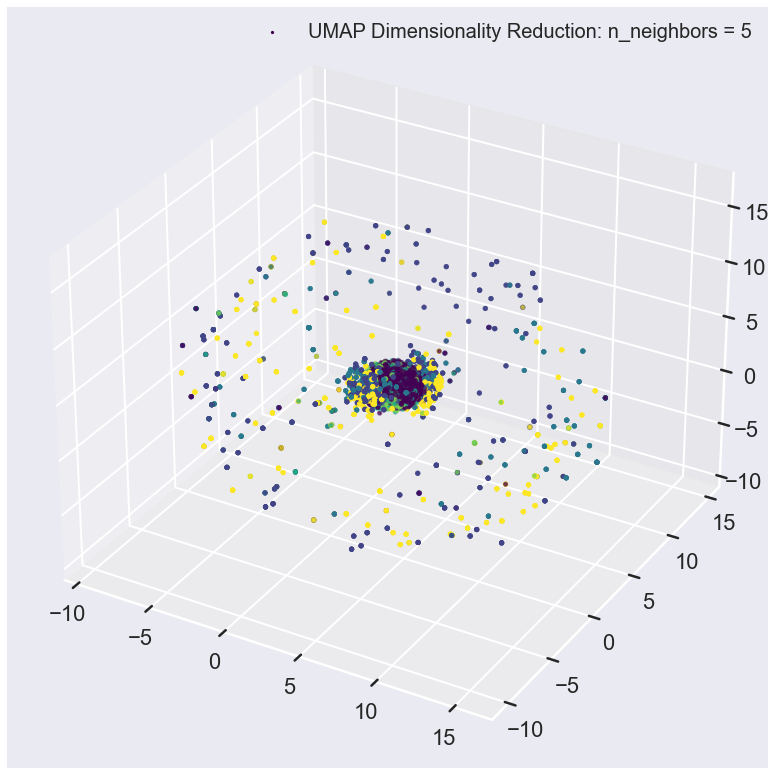

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    model_name accuracy_score precision_score recall_score  \
2                Random Forest       0.535865        0.533219     0.534441   
6           K Nearest Neighbor       0.488279        0.482217     0.486853   
3               Decsision Tree       0.474449        0.473876     0.472887   
4                     AdaBoost       0.345523        0.344976      0.34582   
7          Logistic Regression       0.220347        0.212844     0.218875   
5         Gaussian Naive Bayes       0.236053        0.307275     0.238239   
1  Stochastic Gradient Descent       0.198781        0.176817     0.196936   
0                        Dummy       0.162916        0.027153     0.166667   

   f1_score  
2  0.532672  
6  0.480418  
3  0.473308  
4  0.340514  
7  0.209706  
5  0.198945  
1  0.114978  
0  0.046698  


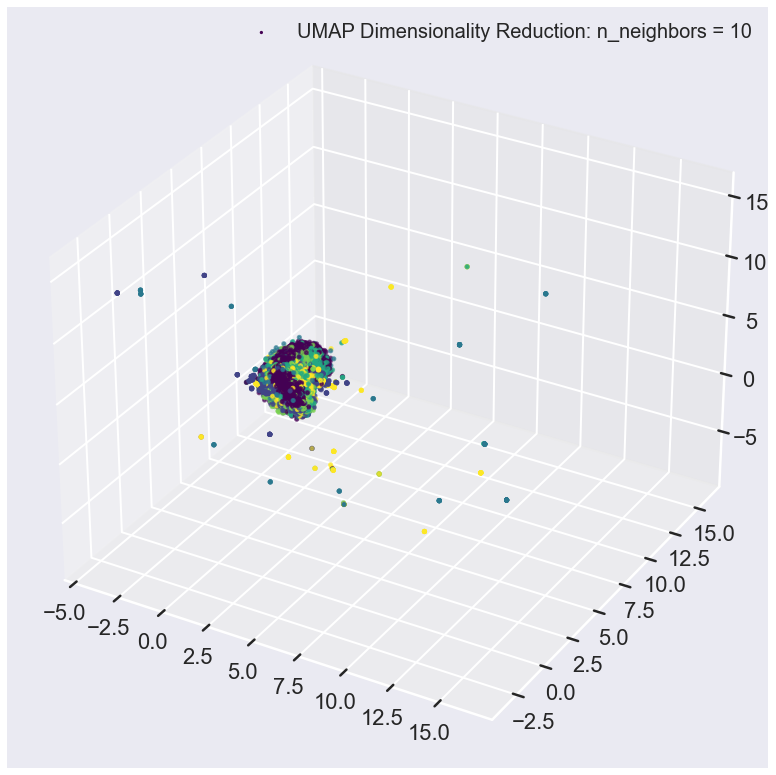

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    model_name accuracy_score precision_score recall_score  \
2                Random Forest       0.570792         0.56741      0.57029   
6           K Nearest Neighbor       0.553211        0.546037     0.552585   
3               Decsision Tree       0.485466        0.485283     0.485059   
4                     AdaBoost       0.423113         0.41267     0.422055   
5         Gaussian Naive Bayes       0.227379        0.273739     0.227556   
7          Logistic Regression        0.22527        0.232461     0.225502   
1  Stochastic Gradient Descent       0.191045        0.330495     0.193344   
0                        Dummy       0.162916        0.027153     0.166667   

   f1_score  
2  0.568212  
6   0.54642  
3  0.485003  
4   0.41246  
5  0.216911  
7  0.215231  
1  0.102735  
0  0.046698  


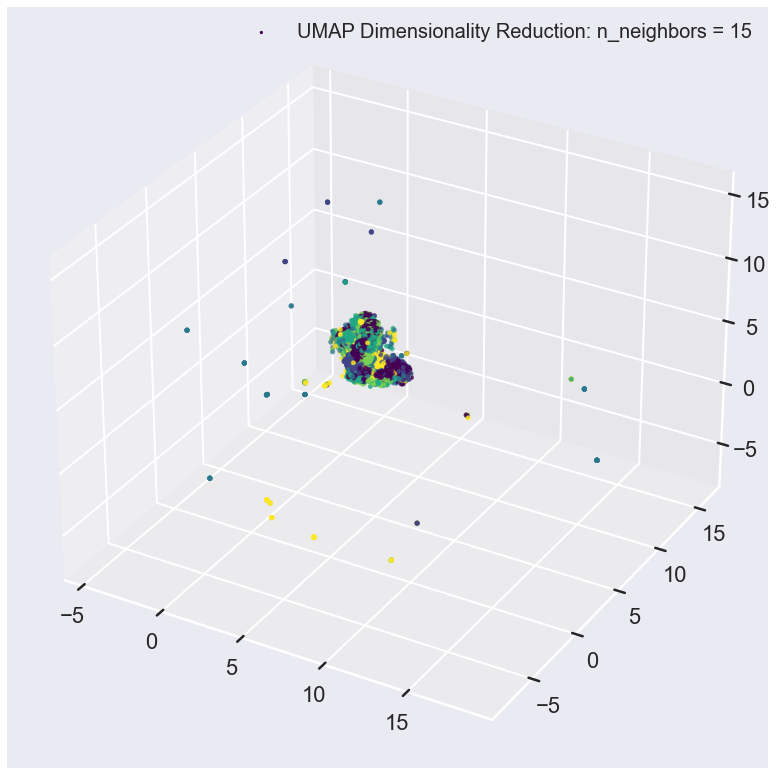

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    model_name accuracy_score precision_score recall_score  \
2                Random Forest       0.646742        0.648154     0.646081   
6           K Nearest Neighbor       0.637365         0.63827      0.63662   
3               Decsision Tree       0.557196        0.556863     0.556681   
4                     AdaBoost       0.424285        0.412152     0.424049   
7          Logistic Regression       0.225035        0.223381      0.22497   
5         Gaussian Naive Bayes       0.174871        0.186782     0.174371   
1  Stochastic Gradient Descent       0.146976        0.225276     0.150243   
0                        Dummy       0.162916        0.027153     0.166667   

   f1_score  
2  0.646104  
6  0.634671  
3  0.556551  
4  0.413208  
7  0.199231  
5  0.166034  
1  0.051989  
0  0.046698  


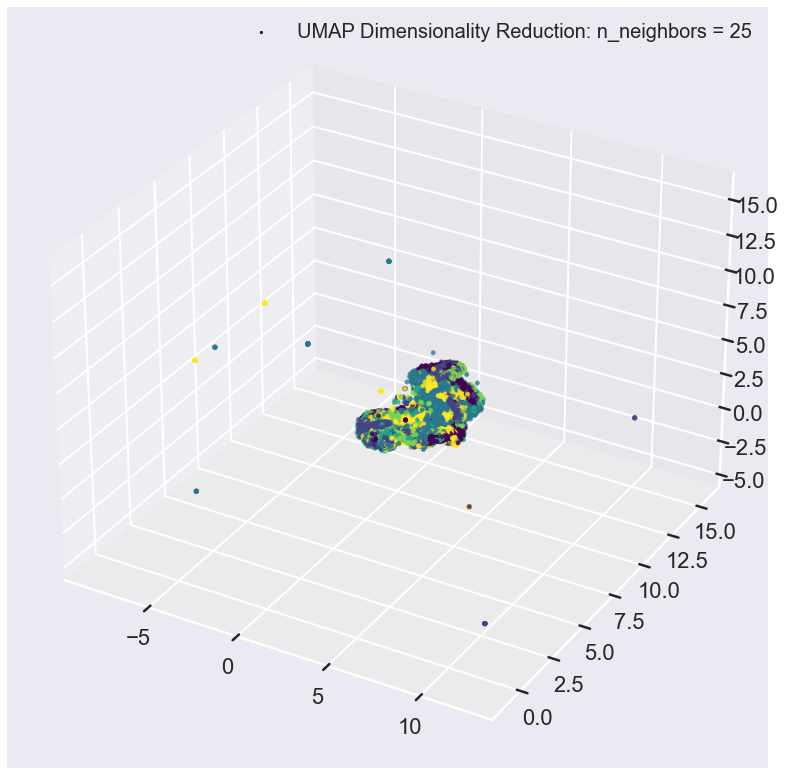

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
2                Random Forest       0.637834        0.637472     0.637266   
6           K Nearest Neighbor       0.634787        0.634925     0.634025   
3               Decsision Tree       0.567042        0.566935      0.56655   
4                     AdaBoost       0.319972        0.321711     0.318774   
5         Gaussian Naive Bayes       0.232302        0.237059     0.231709   
7          Logistic Regression       0.220581        0.215112     0.220623   
1  Stochastic Gradient Descent       0.205345        0.154864      0.20802   
0                        Dummy       0.162916        0.027153     0.166667   

   f1_score  
2  0.636928  
6  0.632645  
3  0.566667  
4  0.313158  
5  0.218795  
7  0.197375  
1  0.100287  
0  0.046698  


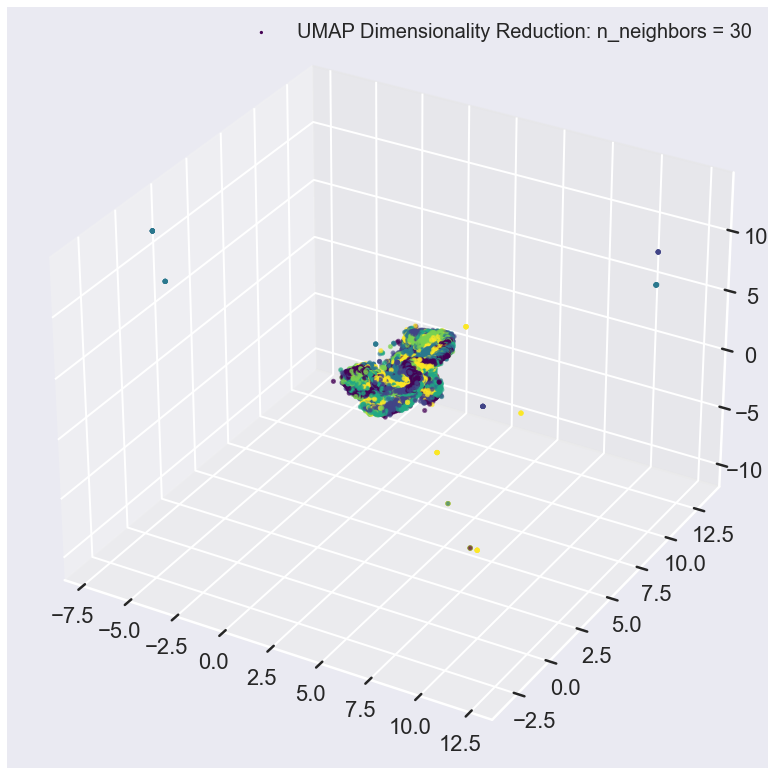

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.660103        0.663486     0.659739   
2                Random Forest       0.654712        0.655216     0.654546   
3               Decsision Tree       0.587201        0.586552     0.587251   
4                     AdaBoost       0.323019        0.321137     0.323591   
5         Gaussian Naive Bayes       0.217534        0.233284      0.21881   
7          Logistic Regression       0.219878        0.190071     0.221257   
1  Stochastic Gradient Descent       0.198781        0.099369     0.201304   
0                        Dummy       0.162916        0.027153     0.166667   

   f1_score  
6  0.658731  
2   0.65438  
3  0.586666  
4  0.317145  
5  0.206767  
7  0.200307  
1  0.096121  
0  0.046698  


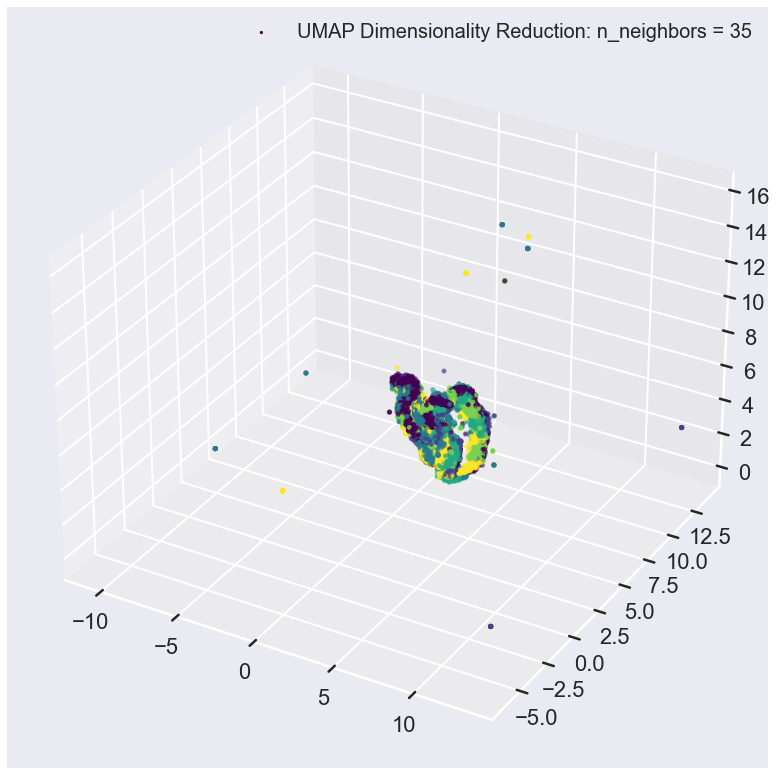

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.706282        0.707082     0.705755   
2                Random Forest       0.702063        0.702466     0.701656   
3               Decsision Tree       0.632911        0.633865     0.632483   
4                     AdaBoost       0.355368        0.349084     0.355078   
5         Gaussian Naive Bayes       0.214955        0.233246     0.213972   
7          Logistic Regression       0.218003        0.181929     0.216733   
1  Stochastic Gradient Descent       0.164323        0.204514     0.165943   
0                        Dummy       0.162916        0.027153     0.166667   

   f1_score  
6  0.705017  
2   0.70186  
3  0.633078  
4  0.346892  
5  0.203125  
7  0.181573  
1   0.04843  
0  0.046698  


In [24]:
neighbors = [5,10,15,25,30,35]

def umap_plot(neighbors):
    for i in neighbors:
        fit = umap.UMAP(n_neighbors = i,
                        min_dist = .1,
                        n_components = 3,
                        metric = 'euclidean')
        data_umap = fit.fit_transform(X_res)

    
        sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data_umap[:,0], data_umap[:,1], data_umap[:,2], c=y_res, s=10, cmap='viridis')
        leg = plt.legend(['UMAP Dimensionality Reduction: n_neighbors = {}'.format(i)], loc='best', borderpad=0.3, 
                         shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                         markerscale=0.4)
        leg.get_frame().set_alpha(0.4)
        leg.set_draggable(state=True)
        plt.show()
        
        
        
        
        model_dict = {'Dummy' : DummyClassifier(random_state=42),
                      'Stochastic Gradient Descent' : SGDClassifier(random_state=42, loss='modified_huber'),
                      'Random Forest': RandomForestClassifier(random_state=42),
                      'Decsision Tree': DecisionTreeClassifier(random_state=42),
                      'AdaBoost': AdaBoostClassifier(random_state=42),
                      'Gaussian Naive Bayes': GaussianNB(),
                      'K Nearest Neighbor': KNeighborsClassifier(),
                      'Logistic Regression': LogisticRegression()}

#Train test split with stratified sampling for evaluation
        X_train, X_test, y_train, y_test = train_test_split(data_umap, 
                                                            y_res, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            random_state = 3)

#Function to get the scores for each model in a df
        def model_score_df(model_dict):   
            model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
            for k,v in model_dict.items():   
                model_name.append(k)
                v.fit(X_train, y_train)
                y_pred = v.predict(X_test)
                ac_score_list.append(accuracy_score(y_test, y_pred))
                p_score_list.append(precision_score(y_test, y_pred, average='macro'))
                r_score_list.append(recall_score(y_test, y_pred, average='macro'))
                f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
                model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
                model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
                model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
            return model_comparison_df

        print(model_score_df(model_dict))
        
        
        
umap_plot(neighbors)

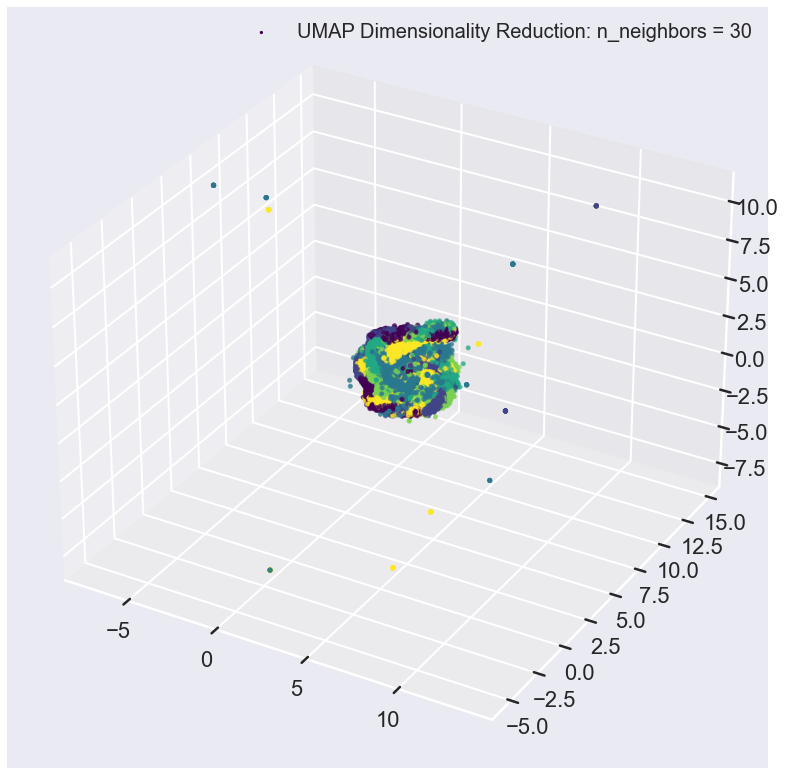

,model_name,accuracy_score,precision_score,recall_score,f1_score
3,K Nearest Neighbor,0.771449,0.771531,0.771197,0.769778
0,Random Forest,0.766292,0.76587,0.766151,0.764938
1,Decsision Tree,0.70722,0.706707,0.70708,0.706616
2,AdaBoost,0.424988,0.419214,0.425589,0.416694


In [27]:
fit = umap.UMAP(n_neighbors = 30,
                min_dist = .1,
                n_components = 3,
                metric = 'euclidean')

data_umap = fit.fit_transform(X_res)

sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_umap[:,0], data_umap[:,1], data_umap[:,2], c=y_res, s=10, cmap='viridis')
leg = plt.legend(['UMAP Dimensionality Reduction: n_neighbors = 30'], loc='best', borderpad=0.3, 
                  shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'), markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()
        
model_dict = {'Random Forest': RandomForestClassifier(random_state=42),
              'Decsision Tree': DecisionTreeClassifier(random_state=42),
              'AdaBoost': AdaBoostClassifier(random_state=42),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(data_umap, 
                                                    y_res, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)



In [ ]:
#KNN
n_neighbors = [5,7,10,15]
weights = ['uniform','distance']
leaf_size = [5,10,30,50]
p = [1,2]
n_jobs = [-1]

clf = KNeighborsClassifier()

params = dict(n_neighbors = n_neighbors,
              weights = weights,
              leaf_size = leaf_size,
              p = p,
              n_jobs = n_jobs)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=5,
                          verbose=1, 
                          n_jobs=-1)

knn_best_model = gridsearch.fit(X_res, y_res)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [174]:
KNN_best = gridsearch.best_params_
print(KNN_best)

{'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}


In [25]:
knn_best_model = KNeighborsClassifier(leaf_size=5,
                                      n_jobs=-1,
                                      n_neighbors=5,
                                      p =2,
                                      weights='distance')

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


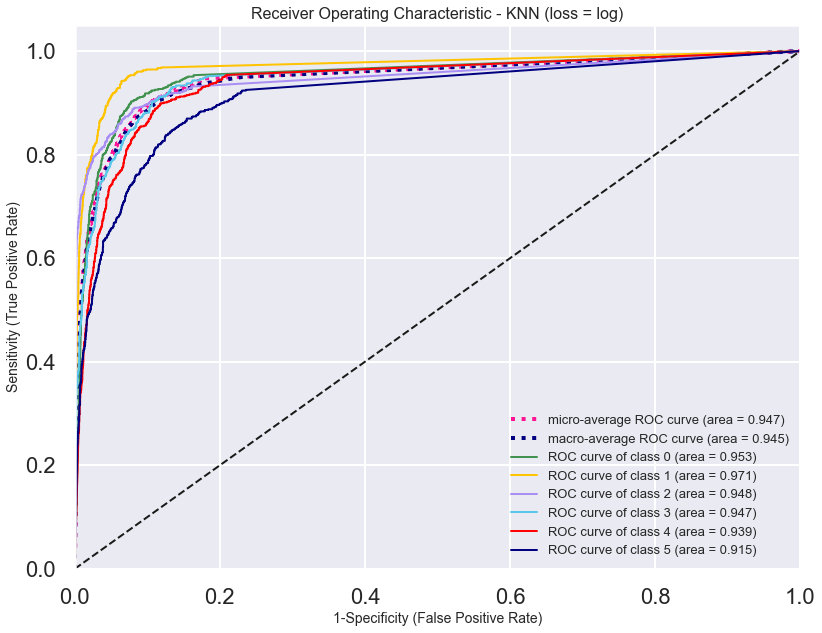

In [40]:
#Plot AUC - SGD
import numpy as np
#Binarize the labels
y_b = label_binarize(y_res, classes = [0, 1, 2, 3, 4, 5])
n_classes = y_b.shape[1]
#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(data_umap,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            random_state = 3)

#Learn to predict each class against the other
KNN_classifier = OneVsRestClassifier(knn_best_model)
y_score = KNN_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)



#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA', 'red', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - KNN (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

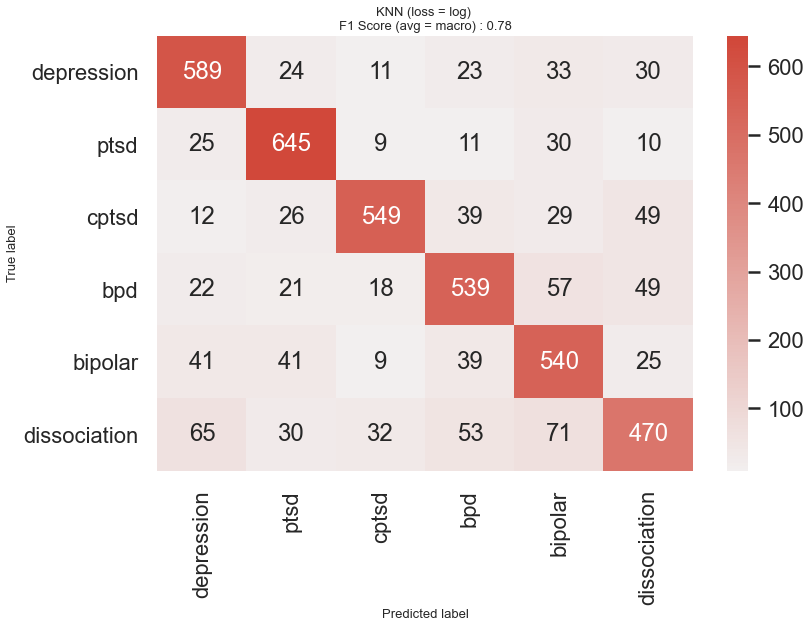

In [45]:
#Train test split with stratified sampling. Using non-binarized labels
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(data_umap, 
                                                            y_res, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            random_state = 3)
#Fit the training data
knn_best_model.fit(X_train_c, y_train_c)
y_pred = knn_best_model.predict(X_test_c)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test_c, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'], 
                     columns = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('KNN (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test_c, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()


In [48]:
unseen = df_holdout['text']
unseen = unseen.apply(clean_text)
unseen = unseen.apply(lambda x: TOKENIZER.tokenize(x))
unseen = unseen.apply(lambda x: word_lemmatizer(x))
unseen.dropna()
for text in unseen:
    if text == []:
        text.append('0')
unseen = unseen.astype('str')


X_unseen_tfidf = vectorizer.fit_transform(unseen).toarray() 
X_unseen = fit.fit_transform(X_unseen_tfidf)

knn_best_model.fit(X_res,y_res)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['pred_knn'] = knn_best_model.predict(X_unseen)


label_num_dict = {0: 0,
                  1: 1,
                  2: 2,
                  3: 3,
                  4: 4,
                  5: 5}
labels = ['0','1','2','3','4','5']

df_holdout['correct'] = df_holdout['label'].map(label_num_dict)
df_holdout = df_holdout[['text', 'label', 'pred_knn', 'correct']]

print(accuracy_score(df_holdout['correct'], df_holdout['pred_knn']))
print(classification_report(df_holdout['correct'], df_holdout['pred_knn'], target_names = labels))
df_holdout

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\umap\umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 3 while Y.shape[1] == 25341

In [171]:
for i in df_holdout['pred_knn']:
    print(i)

5
5
5
5
5
0
5
5
5
5
0
5
0
0
0
5
0
5
0
5
0
0
0
5
0
5
0
0
5
5


In [114]:
#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(data_lsa, 
                                                    y, 
                                                    stratify = y,
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    random_state = 3)


model_score_df(model_dict)


C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model_name,accuracy_score,precision_score,recall_score,f1_score
1,Stochastic Gradient Descent,0.651139,0.657614,0.625801,0.630436
7,Logistic Regression,0.649799,0.684523,0.596874,0.617991
5,Gaussian Naive Bayes,0.470845,0.470944,0.485293,0.461829
4,AdaBoost,0.48559,0.468784,0.446831,0.454315
2,Random Forest,0.468499,0.609039,0.382559,0.38546
3,Decsision Tree,0.321381,0.28965,0.288622,0.288824
6,K Nearest Neighbor,0.288874,0.292704,0.271883,0.261683
0,Dummy,0.235925,0.039321,0.166667,0.06363


In [ ]:
loss =  ['modified_huber']
penalty = ['l2','l1']
alpha = [1e-6, 1e-3, 1e-1, 1e0]
max_iter = [5, 1000, 10000]
tol = [None, 1e-3]
random_state = [3]


params = {'loss': loss,
          'penalty': penalty,
          'alpha': alpha,
          'max_iter': max_iter,
          'tol': tol,
          'random_state': random_state}



clf = SGDClassifier()

gridsearch = GridSearchCV(clf,
                          params,
                          cv = 5,
                          verbose = 1, 
                          n_jobs = -1)

sgd_best_model = gridsearch.fit(X,y)  

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [ ]:
sgd_best = gridsearch.best_params_
print(sgd_best)

In [270]:
import praw
import pandas as pd


###grab token from reddit###
reddit = praw.Reddit(client_id='KXhnkec1dP7COg', 
                     client_secret='cyAwGdx77eOM2zQfMBOjcYee8RnehQ', 
                     user_agent='AI-ADHD')

sub_0 = reddit.subreddit('depression')
sub_1 = reddit.subreddit('ptsd')
sub_2 = reddit.subreddit('cptsd')
sub_3 = reddit.subreddit('bpd')
sub_4 = reddit.subreddit('bipolar')
sub_5 = reddit.subreddit('dissociation')

dep = sub_0.new(limit=1000)
ptsd = sub_1.new(limit=1000)
cptsd = sub_2.new(limit=1000)
bpd = sub_3.new(limit=1000)
bipolar = sub_4.new(limit=1000)
diss = sub_5.new(limit=1000)




unseen = {'body':[],
          'label':[]}

for post in dep:
    unseen['body'].append(post.selftext)
    unseen['label'].append('0')
for post in ptsd:
    unseen['body'].append(post.selftext)
    unseen['label'].append('1')
for post in cptsd:
    unseen['body'].append(post.selftext)
    unseen['label'].append('2')
for post in bpd:
    unseen['body'].append(post.selftext)
    unseen['label'].append('3')
for post in bipolar:
    unseen['body'].append(post.selftext)
    unseen['label'].append('4')
for post in diss:
    unseen['body'].append(post.selftext)
    unseen['label'].append('5')
    

unseen = pd.DataFrame(unseen)
    
unseen['body'] = unseen['body'].apply(clean_text)
unseen['body'] = unseen['body'].apply(lambda x: TOKENIZER.tokenize(x))
unseen['body'] = unseen['body'].apply(lambda x: word_lemmatizer(x))

In [271]:
unseen

,body,label
0,"[year, ago, really, lot, reason, believe, fact...",0
1,"[sub, reddit, going, something, may, feel, emp...",0
2,"[every, day, every, moment, blend, together, d...",0
3,"[hey, know, tough, winter, thing, seem, little...",0
4,"[anyone, try, getcerebral, look, legit, talk, ...",0
...,...,...
5975,"[scary, reading, post, say, theyve, going, dis...",5
5976,[],5
5977,"[crazy, thing, connecting, reality, cognitive,...",5
5978,"[dealing, severe, panic, disorder, intense, di...",5


In [54]:
penalty = ['l2','l1']
C = [1e-6, 1e-3, 1e-1, 1e0]
max_iter = [5, 1000, 10000]
tol = [None, 1e-3]
random_state = [3]


params = {'penalty': penalty,
          'C': C,
          'max_iter': max_iter,
          'tol': tol,
          'random_state': random_state}



clf = LogisticRegression()

gridsearch = GridSearchCV(clf,
                          params,
                          cv = 5,
                          verbose = 1, 
                          n_jobs = -1)

sgd_best_model = gridsearch.fit(X,y)  

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   14.7s finished


In [ ]:
sgd_best = gridsearch.best_params_
print(sgd_best)

{'C': 1.0, 'max_iter': 1000, 'penalty': 'l2', 'random_state': 3, 'tol': 0.001}


In [35]:
sgd_best_model = SGDClassifier(alpha=1e-06,
                               loss='modified_huber',
                               max_iter=10000,
                               penalty='l1',
                               tol = None,
                               random_state = 3)

C:\Users\chung\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:39: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


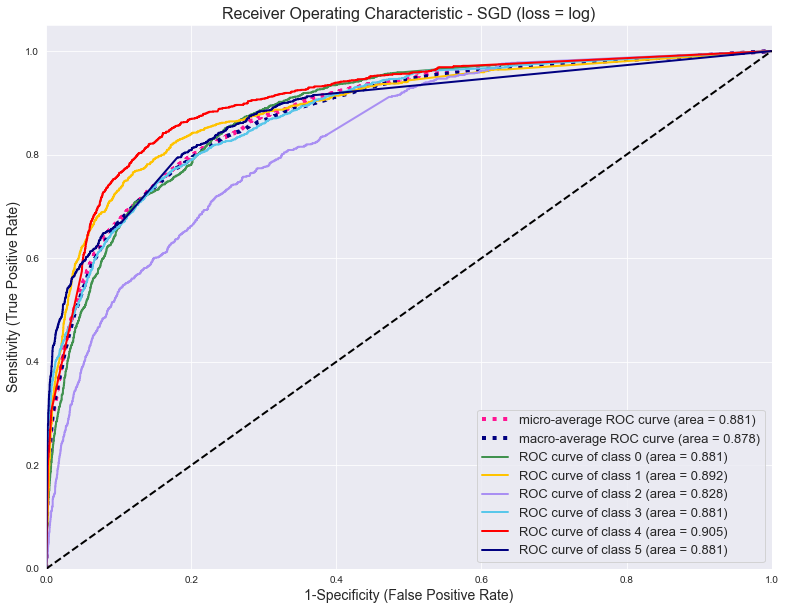

In [38]:
#Plot AUC - SGD
import numpy as np
#Binarize the labels
y_b = label_binarize(y, classes = [0, 1, 2, 3, 4, 5])
n_classes = y_b.shape[1]

#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            stratify = y,
                                                            random_state = 3)

#Learn to predict each class against the other
sgd_classifier = OneVsRestClassifier(sgd_best_model)

y_score = sgd_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA', 'red', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - SGD (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

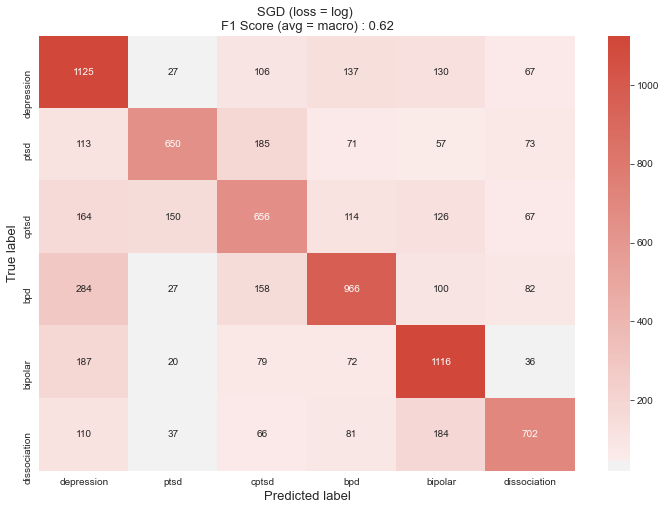

In [40]:
#Train test split with stratified sampling. Using non-binarized labels
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
#Fit the training data
sgd_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = sgd_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'], 
                     columns = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('SGD (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()
